###Requirements in this project :
* pandas
* seaborn
* tqdm
* zipfile
* pathlib
* numpy
* matplotlib
* tensorflow
* sklearn
* keras


# 1.Load the dataset
In this part we want to exctract our data to work on it.<br>
Our Dataset is a set of sports images, divided into 7 folders : baseball,
 basketball, boxing,  football,  formula1,  swimming and tennis.<br>
 It is located on google drive as a zip file.

In [1]:
import seaborn as sns
import tqdm
import gdown
import zipfile

# Load the dataset from google drive
dataset_url = 'https://drive.google.com/file/d/1dmX5laQwy4JYHSPHO2H7MX6JYzKRH7iO/view?usp=sharing'
gdown.download(dataset_url, output='data.zip', quiet=False, fuzzy=True)

# extract dataset from zip file
with zipfile.ZipFile("data.zip","r") as zf:
    for member in tqdm.tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, 'data')
        except zipfile.error as e:
            pass
print('\nExtract of the dataset completed')

Downloading...
From (original): https://drive.google.com/uc?id=1dmX5laQwy4JYHSPHO2H7MX6JYzKRH7iO
From (redirected): https://drive.google.com/uc?id=1dmX5laQwy4JYHSPHO2H7MX6JYzKRH7iO&confirm=t&uuid=b754b90b-5c18-4435-bde6-3f8b506391d1
To: /content/data.zip
100%|██████████| 84.7M/84.7M [00:02<00:00, 39.7MB/s]
Extracting : 100%|██████████| 3059/3059 [00:01<00:00, 1874.12it/s]


Extract of the dataset completed


In [2]:
import pathlib

# Count the number of images in the dataset
data_dir = pathlib.Path('./data')
count = len(list(data_dir.glob('*/*.*')))
print(f"The dataset contains {count} images")

The dataset contains 3059 images


In [3]:
# Divide the dataset into our 7 sport categories
categories = ['baseball', 'basketball', 'boxing', 'football', 'formula1', 'swimming', 'tennis']
label2id_dict = dict((name, index) for index, name in enumerate(categories))
id2label_dict = dict((index, name) for index, name in enumerate(categories))
dataset = []
for category in categories:
    dataset.append(list(data_dir.glob(category+'/*.*')))
    print(f"number of {category} images = {len(list(data_dir.glob(category+'/*.*')))}")

number of baseball images = 437
number of basketball images = 437
number of boxing images = 437
number of football images = 437
number of formula1 images = 437
number of swimming images = 437
number of tennis images = 437


In [4]:
from PIL import Image
import os
import pathlib

# List to stock the images dimensions
image_dimensions = []

# Browse the folder and its subfolders to find all images
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        try:
            # Filter and read only image files
            if file.lower().endswith(('.jpg', '.jpeg')):
                # Build the full path to the file
                filepath = os.path.join(subdir, file)
                # Open the image and get its dimensions
                with Image.open(filepath) as img:
                    width, height = img.size
                    image_dimensions.append((width, height))
                    #print(f"{file}: {width}x{height}")
        except Exception as e:
            print(f"Error reading image {file}: {e}")

# Find the average size
if image_dimensions:
    average_width = round(sum(dim[0] for dim in image_dimensions) / len(image_dimensions))
    average_height = round(sum(dim[1] for dim in image_dimensions) / len(image_dimensions))
    print(f"average images size = {average_width} x {average_height}")
else:
    print("No image dimensions found.")

average images size = 476 x 322


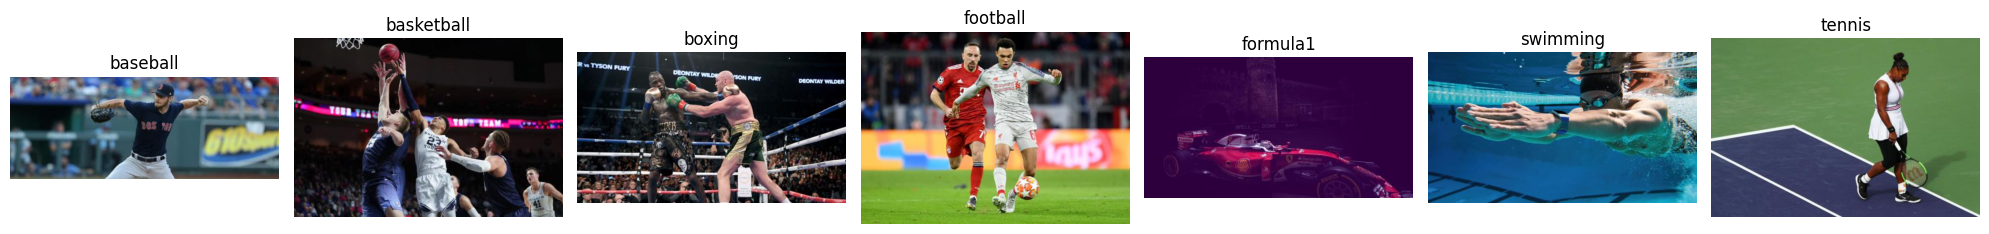

In [5]:
# We want to see one image per category now
import matplotlib.pyplot as plt
import PIL

plt.figure(figsize=(20, 20))
for i, category in enumerate(categories):
    image = dataset[i][0]
    plt.subplot(1, 7, i+1)
    plt.imshow(PIL.Image.open(str(image)))
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 2.Process
In this part, we want to split the dataset into training and testing : 80% for training and 20% for testing but you can choose what you want. We also want an image of 128x128 because it's better for our accuracy results.<br>
Then we need to modify and normalize the images to have better images to process and at the end we flatten the images.

In [6]:
import numpy as np
import tensorflow as tf

seed = 55
# Set seed for tensorflow take
tf.random.set_seed(seed)
# Set seed for numpy
np.random.seed(seed)
print(f"Seed set as {seed}")

Seed set as 55


###2.1. Split the dataset into training and testing

Images are adjusted to a size of 128x128 pixels, with the color scheme being switched to RGB. This resizing uses the Lanczos5 interpolation technique, which is advised for reducing the size of images.

In [7]:
# split the dataset into training and testing
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 80% of the images are used for training, 20% for testing
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(128, 128),
    batch_size=1,
    label_mode='categorical',
    shuffle=True,
    color_mode="rgb",
    interpolation='lanczos5'
)

test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=1,
    label_mode='categorical',
    shuffle=True,
    color_mode="rgb",
    interpolation='lanczos5'
)

# print the shape of the first image
for images, labels in train_ds.take(1):
    print(f"Shape of the 1st image for exemple = {images[0].shape}")

Found 3059 files belonging to 7 classes.
Using 2448 files for training.
Found 3059 files belonging to 7 classes.
Using 611 files for validation.
Shape of the 1st image for exemple = (128, 128, 3)


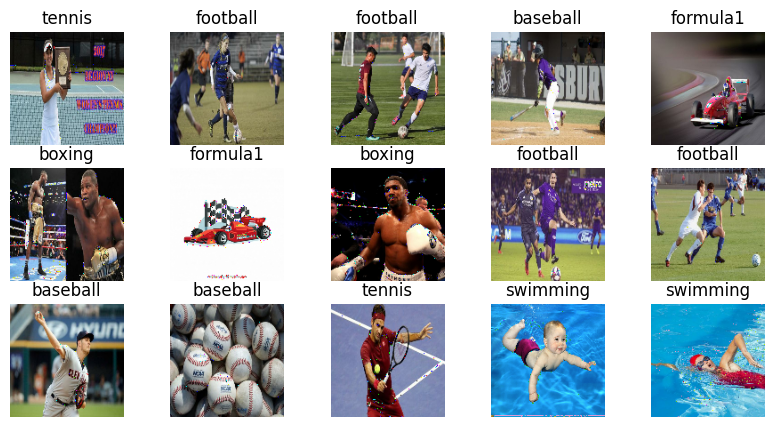

In [8]:
# Plot the firsts 15 images of the training dataset
plt.figure(figsize=(10, 5))
i = 0
for images, labels in train_ds.take(15, ):
    image = images[0]
    label = labels[0]
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"), cmap='gray')
    plt.title(id2label_dict[label.numpy().argmax()])
    plt.axis("off")
    i += 1

### 2.2.  Adjustment and Normalization of the images
Each image is 128x128 pixels with 3 channels (rgb). The labels are one-hot encoded. In this part, we will use the keras preprocessing layers to get a better image with the following techniques:
* RandomZoom : Randomly zooms the image
* RandomContrast : Randomly changes the contrast of the image
* Normalization : Normalizes the image

In [9]:
from keras.preprocessing.image import ImageDataGenerator
# Adjust the image using keras preprocessing layers
data_adjustment = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.4),
    tf.keras.layers.experimental.preprocessing.Normalization()
])

# augment the image in train_ds
train_ds_adj = train_ds.map(lambda x, y: (data_adjustment(x, training=True), y))
test_ds_adj = test_ds.map(lambda x, y: (data_adjustment(x, training=True), y))


print("End of the adjustment and normalization")

End of the adjustment and normalization


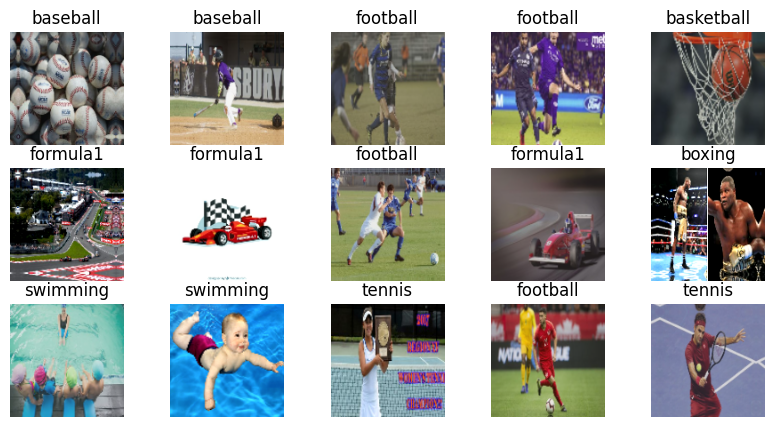

In [10]:
# plot the first 15 images of the training dataset after adjustment and normalization
plt.figure(figsize=(10, 5))
i = 0
for images, labels in train_ds_adj.take(15, ):
    image = images[0]
    label = labels[0]
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"), cmap='gray')
    plt.title(id2label_dict[label.numpy().argmax()])
    plt.axis("off")
    i += 1

### 2.3. Flatten the images using VGG16
We will use the pre-trained VGG16 model on ImageNet to flatten the images. The VGG16 is a conventional neural network (CNN) architecture for image classification, it prepares an image dataset for further training by extracting features via the model and normalizing pixel values, all while retaining the original structure and weights of the VGG16 model for feature extraction.It is recommended for vectorizing images.

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model (excluding the top classification layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the VGG16 layers to prevent further training
vgg16.trainable = False

# Add a flatten layer to convert the output of VGG16 into a 1D array
flatten_layer = Flatten()(vgg16.output)

# Create a new model that takes VGG16 output as input and outputs the flattened representation
flatten_model = Model(inputs=vgg16.input, outputs=flatten_layer)

# Apply the flatten_model to train_ds_aug and test_ds_aug
train_ds = train_ds_adj.map(lambda x, y: (flatten_model(x), y))
test_ds = test_ds_adj.map(lambda x, y: (flatten_model(x), y))

# # normalize the pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# print the shape of the first image in the training dataset
for images, labels in train_ds.take(1):
    print(f"Shape of the image in TRAIN = {images[0].shape}")

for images, labels in test_ds.take(1):
    print(f"Shape of the image in TEST = {images[0].shape}")

58889256/58889256 [==============================] - 3s 0us/step
Shape of the image in TRAIN = (8192,)
Shape of the image in TEST = (8192,)


#3. Build the model

In [12]:
# Store parts of the dataset in cache memory.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(5000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

###3.1. Linear SVM
The Linear SVM model operates as a linear classifier, employing the hinge loss function to enhance the margin separating the classes. This model is constructed using several dense layers, interspersed with dropout layers. The incorporation of multiple dense layers aids in delineating a more intricate decision boundary. Meanwhile, the dropout layers are instrumental in mitigating overfitting. Within this framework, the squared hinge loss function, defined as $L(y, f(x)) = max(0, 1-y*f(x))^2$ , is utilized.<br>
 This particular function imposes a greater penalty on incorrectly classified points. Our experimentation indicates that this loss function outperforms the traditional hinge loss function in effectiveness.

In [13]:
import tensorflow as tf
from keras import Sequential

# Build an SVM model with linear kernel
gamma = 0.001

linearSVM_model = Sequential([
    tf.keras.layers.Input(shape=(8192,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(gamma))
])

# Compile the model
linearSVM_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SquaredHinge(),
    metrics=['accuracy']
)
print("Build of SVM model with linear kernel is finish")

Build of SVM model with linear kernel is finish


Epoch 1/25
77/77 [==============================] - 613s 2s/step - loss: 1.2093 - accuracy: 0.2876 - val_loss: 1.1158 - val_accuracy: 0.5679
Epoch 2/25
77/77 [==============================] - 3s 34ms/step - loss: 1.1212 - accuracy: 0.5057 - val_loss: 1.0490 - val_accuracy: 0.7283
Epoch 3/25
77/77 [==============================] - 2s 28ms/step - loss: 1.0558 - accuracy: 0.6609 - val_loss: 1.0026 - val_accuracy: 0.7741
Epoch 4/25
77/77 [==============================] - 3s 33ms/step - loss: 1.0132 - accuracy: 0.7439 - val_loss: 0.9818 - val_accuracy: 0.8151
Epoch 5/25
77/77 [==============================] - 3s 33ms/step - loss: 0.9859 - accuracy: 0.8002 - val_loss: 0.9714 - val_accuracy: 0.8036
Epoch 6/25
77/77 [==============================] - 3s 38ms/step - loss: 0.9713 - accuracy: 0.8219 - val_loss: 0.9607 - val_accuracy: 0.8298
Epoch 7/25
77/77 [==============================] - 2s 28ms/step - loss: 0.9559 - accuracy: 0.8529 - val_loss: 0.9633 - val_accuracy: 0.8249
Epoch 8/25
77

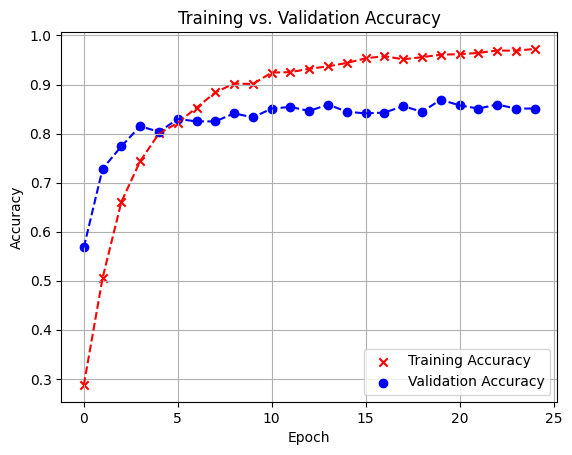

In [14]:
# Train the model
history = linearSVM_model.fit(
    train_ds.batch(32),
    validation_data=test_ds,
    epochs=25,
    workers=8,
    use_multiprocessing=True
)

# Calculating the range for x-axis
epochs_range = range(len(history.history['accuracy']))

# Plot the training and validation accuracy
plt.scatter(epochs_range, history.history['accuracy'], label='Training Accuracy', color='red', marker='x')
plt.scatter(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='blue', marker='o')

# Connect the accuracy points with lines
plt.plot(epochs_range, history.history['accuracy'], color='red', linestyle='--')
plt.plot(epochs_range, history.history['val_accuracy'], color='blue', linestyle='--')


plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.grid(True)
plt.show()

1.	Accuracy Increase: The model's training accuracy starts at 28.76% and consistently increases to reach 97.26% by the last epoch. Similarly, the validation accuracy improves from 56.79% to 85.11%. These are strong indicators of the model learning effectively from the training data.
2.	Loss Reduction: Both the training and validation loss decrease over time. The training loss goes from 1.2093 to 0.8820, and our validation loss decreases from 1.1158 to 0.9475. A decreasing loss is a good sign that the model is converging and becoming more confident in its predictions.
3.	Validation Performance: The validation accuracy and loss are good indicators of how well the model generalizes to unseen data. In this case, the validation accuracy ends at a high note (85.11%), suggesting that the model has learned generalizable features rather than just memorizing the training data.
4.	Potential Overfitting: While the training accuracy reaches a very high level (97.26%), validation accuracy caps at 85.11%. This gap suggests a bit of overfitting, where the model performs significantly better on the training data than on unseen data.


In [15]:
import seaborn as sns
# Confusion matrix
test_labels = test_ds.map(lambda x, y: y).unbatch()
test_labels = np.argmax(list(test_labels.as_numpy_iterator()), axis=1)
test_predictions = np.argmax(linearSVM_model.predict(test_ds.map(lambda x, y: x)), axis=1)
cm_linearSVM = tf.math.confusion_matrix(
    test_labels,
    test_predictions,
    num_classes=7
)

611/611 [==============================] - 1s 2ms/step


###3.2. Clustered Linear SVM
Primarily aimed at model compression to minimize its size, the Clustered Linear SVM technique also significantly enhances model performance. By clustering the model's weights, it reduces the parameter count, achieving a leaner model that not only demands less storage but also operates more efficiently. This approach not only streamlines the model for better deployment but also potentially boosts its accuracy and performance, making it a valuable strategy for optimizing machine learning models where efficiency and effectiveness are paramount.




In [16]:
!pip install tensorflow-model-optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.4 MB/s eta 0:00:00


In [17]:
import tensorflow_model_optimization as tfmot
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 20,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(linearSVM_model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)

clustered_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=opt,
  metrics=['accuracy'])

print("Cluster the whole SVM Linear model is finish")

Cluster the whole SVM Linear model is finish


Epoch 1/10
77/77 [==============================] - 179s 2s/step - loss: 0.0594 - accuracy: 0.9922 - val_loss: 0.9668 - val_accuracy: 0.8543
Epoch 2/10
77/77 [==============================] - 158s 2s/step - loss: 0.0506 - accuracy: 0.9931 - val_loss: 0.9484 - val_accuracy: 0.8560
Epoch 3/10
77/77 [==============================] - 156s 2s/step - loss: 0.0423 - accuracy: 0.9935 - val_loss: 0.9238 - val_accuracy: 0.8576
Epoch 4/10
77/77 [==============================] - 156s 2s/step - loss: 0.0349 - accuracy: 0.9943 - val_loss: 0.9126 - val_accuracy: 0.8560
Epoch 5/10
77/77 [==============================] - 156s 2s/step - loss: 0.0298 - accuracy: 0.9951 - val_loss: 0.9132 - val_accuracy: 0.8576
Epoch 6/10
77/77 [==============================] - 100s 1s/step - loss: 0.0260 - accuracy: 0.9959 - val_loss: 0.9136 - val_accuracy: 0.8560
Epoch 7/10
77/77 [==============================] - 156s 2s/step - loss: 0.0227 - accuracy: 0.9963 - val_loss: 0.9230 - val_accuracy: 0.8511
Epoch 8/10
77

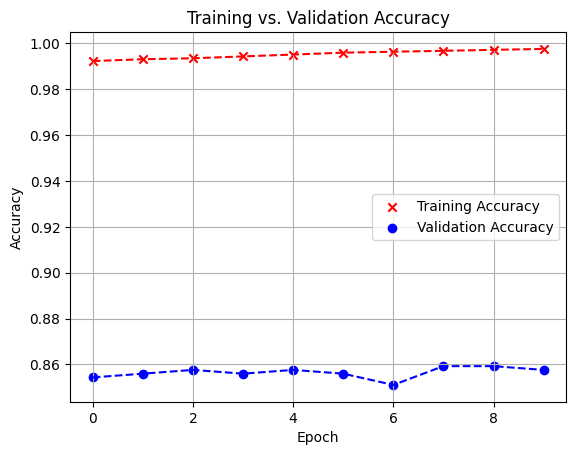

In [18]:
history = clustered_model.fit(
    train_ds.batch(32),
    validation_data=test_ds,
    epochs=10,
    workers=8,
    use_multiprocessing=True
)

# Calculating the range for x-axis
epochs_range = range(len(history.history['accuracy']))

# Plot the training and validation accuracy
plt.scatter(epochs_range, history.history['accuracy'], label='Training Accuracy', color='red', marker='x')
plt.scatter(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='blue', marker='o')

# Connect the accuracy points with lines
plt.plot(epochs_range, history.history['accuracy'], color='red', linestyle='--')
plt.plot(epochs_range, history.history['val_accuracy'], color='blue', linestyle='--')


plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.grid(True)
plt.show()

1.	High Starting Accuracy: The model begins with a remarkably high training accuracy (99.75%) and validation accuracy (85.76%). The high starting point suggests that the model, possibly due to pre-processing with clustering or initialization, begins in a state that is already highly effective at making predictions.
2.	Minimal Accuracy Improvement: Across epochs, the training accuracy slightly increases from 99.22% to 99.75%, and the validation accuracy shows minor fluctuations around the 85% to 86% range. These small changes imply that the model was already near its maximum capability from the beginning of training.
3.	Decreasing Loss: The training loss decreases from 0.0594 to 0.0157, which is good, but given the starting loss was already low, the relative improvement is marginal. The validation loss also decreases slightly before stabilizing, indicating the model's predictions are becoming slightly more confident over time without significantly changing in accuracy.
4.	Validation Performance vs. Training Performance: The gap between training and validation accuracy is more pronounced than in the previous SVM model, with training accuracy near 100% and validation accuracy in the mid-80s percent range. This discrepancy suggests a higher degree of overfitting, where the model is almost perfectly fitting the training data but not improving as much on the validation set.
5.	Potential Overfitting Concerns: The very high training accuracy combined with the much lower validation accuracy suggests that the model might be overfitting to the training data.


In [19]:
# Confusion matrix
test_labels = test_ds.map(lambda x, y: y).unbatch()
test_labels = np.argmax(list(test_labels.as_numpy_iterator()), axis=1)
test_predictions = np.argmax(clustered_model.predict(test_ds.map(lambda x, y: x)), axis=1)
cm_clustered_model = tf.math.confusion_matrix(
    test_labels,
    test_predictions,
    num_classes=7
)

611/611 [==============================] - 104s 170ms/step


In [20]:
# Convert the lists to NumPy arrays
train_lst = list(train_ds.as_numpy_iterator())
x_train, y_train = zip(*train_lst)
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
test_lst = list(test_ds.as_numpy_iterator())
x_test, y_test = zip(*test_lst)
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
#print the first 5 elements of x_train and y_train
print(x_train[:5])
print(y_train[:5])
print(x_test[:5])
print(y_test[:5])
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

[[0.10938102 0.         0.         ... 0.         0.01078239 0.        ]
 [0.         0.         0.         ... 0.         0.         0.04687008]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02203119 0.         0.04850879]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.0830097 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


###3.3. AdaBoost with Decision Tree Classifier
In this approach, we integrate AdaBoost with a decision tree classifier as the foundational model. Utilizing RandomizedSearchCV, we aim to pinpoint the optimal hyperparameters, enhancing the model's efficiency. AdaBoost, known for its applicability to both classification and regression tasks, is selected for its ability to augment model performance significantly. This boosting algorithm improves upon the base decision tree model by iteratively correcting errors, thus offering a more accurate and robust solution.

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

ada_model = AdaBoostClassifier(n_estimators=100, random_state=0)

# train the model and do random grid search with cross-validation and show progress
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.05, 0.1, 0.3, 1, 1.5, 2]}
ada_model = RandomizedSearchCV(ada_model, param_distributions=param_grid, cv=3, n_iter=10, n_jobs=1, verbose=1000)

# Train the model
ada_model.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START learning_rate=0.3, n_estimators=200........................
[CV 1/3; 1/10] END learning_rate=0.3, n_estimators=200;, score=0.526 total time= 1.8min
[CV 2/3; 1/10] START learning_rate=0.3, n_estimators=200........................
[CV 2/3; 1/10] END learning_rate=0.3, n_estimators=200;, score=0.512 total time= 1.8min
[CV 3/3; 1/10] START learning_rate=0.3, n_estimators=200........................
[CV 3/3; 1/10] END learning_rate=0.3, n_estimators=200;, score=0.540 total time= 1.7min
[CV 1/3; 2/10] START learning_rate=0.01, n_estimators=300.......................
[CV 1/3; 2/10] END learning_rate=0.01, n_estimators=300;, score=0.447 total time= 2.6min
[CV 2/3; 2/10] START learning_rate=0.01, n_estimators=300.......................
[CV 2/3; 2/10] END learning_rate=0.01, n_estimators=300;, score=0.515 total time= 2.6min
[CV 3/3; 2/10] START learning_rate=0.01, n_estimators=300.......................
[CV 3/3; 2/

RandomizedSearchCV(cv=3,
                   estimator=AdaBoostClassifier(n_estimators=100,
                                                random_state=0),
                   n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1, 1.5, 2],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500]},
                   verbose=1000)

In [22]:
# evaluate the model
print('Accuracy:', ada_model.score(x_train, y_train))
print("Best score:", ada_model.best_score_)

# print the best hyperparameters
print("Best hyperparameters:", ada_model.best_params_)

# create a confusion matrix
y_pred = ada_model.predict(x_test)
cm_ada_model = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=7
)

Accuracy: 0.6380718954248366
Best score: 0.5261437908496732
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 0.3}


###3.4 AdaBoost with Neural Network
In this configuration, we combine AdaBoost with a neural network as the base model, employing RandomizedSearchCV to efficiently identify optimal hyperparameters. AdaBoost enhances model accuracy by iteratively focusing on challenging cases, while the neural network's flexibility allows for complex pattern recognition. RandomizedSearchCV, by sampling a subset of hyperparameter combinations, offers a balance between exploration and computational efficiency, making it ideal for fine-tuning the sophisticated architecture of neural networks in this boosted ensemble method.

In [23]:
!pip install scikeras


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the MLP model
def create_mlp_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

mlp_model = KerasClassifier(create_mlp_model, epochs=10, batch_size=32, verbose=0)

# Convert y_train_encoded to categorical
y_train_categorical = np.array(y_train_encoded)

# Fit the MLP model
mlp_model.fit(x_train, y_train_categorical)

# Calculate the accuracy score on the test set
mlp_score = mlp_model.score(x_test, y_test_encoded)

ada_mlp_model = AdaBoostClassifier(estimator=mlp_model, n_estimators=100, random_state=0)

# Define the parameter grid for RandomizedSearchCV
param_grid = {'base_estimator__epochs': [5, 10, 20],
              'base_estimator__batch_size': [16, 32, 64],
              'n_estimators': [10, 20, 30],
              'learning_rate': [0.01, 0.1, 1.0]}

# Create the RandomizedSearchCV object
ada_random_search = RandomizedSearchCV(estimator=ada_mlp_model,
                                       param_distributions=param_grid,
                                       cv=2,
                                       n_iter=10,
                                       n_jobs=-1,
                                       verbose=1000)

import logging
logging.getLogger('tensorflow').disabled = True



# Train the model using RandomizedSearchCV
ada_random_search.fit(x_train, y_train_encoded)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


RandomizedSearchCV(cv=2,
                   estimator=AdaBoostClassifier(estimator=KerasClassifier(batch_size=32, epochs=10, model=<function create_mlp_model at 0x7fa2f139b880>, verbose=0),
                                                n_estimators=100,
                                                random_state=0),
                   n_jobs=-1,
                   param_distributions={'base_estimator__batch_size': [16, 32,
                                                                       64],
                                        'base_estimator__epochs': [5, 10, 20],
                                        'learning_rate': [0.01, 0.1, 1.0],
                                        'n_estimators': [10, 20, 30]},
                   verbose=1000)

In [25]:
# evaluate the model
print('Accuracy:', ada_random_search.score(x_test, y_test_encoded))

# evaluate the model ca j'ai ajouté
print("Best score:", ada_random_search.best_score_)
print("Best hyperparameters:", ada_random_search.best_params_)

Accuracy: 0.8527004909983633
Best score: 0.8051470588235294
Best hyperparameters: {'n_estimators': 10, 'learning_rate': 0.01, 'base_estimator__epochs': 5, 'base_estimator__batch_size': 64}


### 3.5 K-Nearest Neighbors
K-Nearest Neighbors stands as a straightforward algorithm known for its commendable performance capabilities. In our implementation, we opt for Cosine Similarity as the distance metric, given its effectiveness with high-dimensional data. To ensure the model operates at its peak, we employ RandomizedSearchCV, a method designed to meticulously search and identify the optimal hyperparameters for the algorithm.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START n_neighbors=3...............................................
[CV 1/3; 1/8] END ................n_neighbors=3;, score=0.721 total time=   0.6s
[CV 2/3; 1/8] START n_neighbors=3...............................................
[CV 2/3; 1/8] END ................n_neighbors=3;, score=0.690 total time=   1.0s
[CV 3/3; 1/8] START n_neighbors=3...............................................
[CV 3/3; 1/8] END ................n_neighbors=3;, score=0.710 total time=   0.9s
[CV 1/3; 2/8] START n_neighbors=7...............................................
[CV 1/3; 2/8] END ................n_neighbors=7;, score=0.743 total time=   0.9s
[CV 2/3; 2/8] START n_neighbors=7...............................................
[CV 2/3; 2/8] END ................n_neighbors=7;, score=0.728 total time=   0.7s
[CV 3/3; 2/8] START n_neighbors=7...............................................
[CV 3/3; 2/8] END ................n_neighbors=7;,

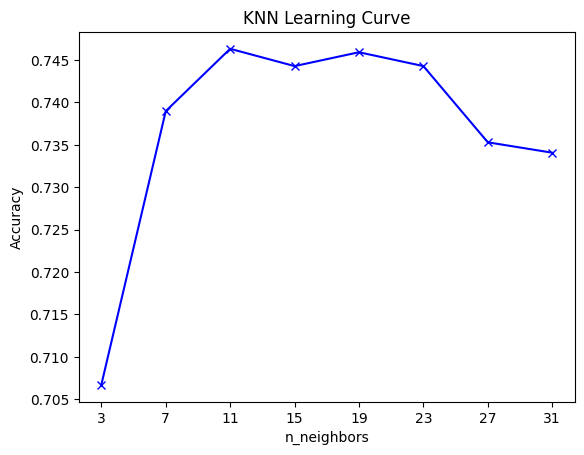

Accuracy: 0.8051470588235294
Best score: 0.7463235294117648
Best hyperparameters: {'n_neighbors': 11}


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# define the model
knn_model = KNeighborsClassifier(n_neighbors=1, metric='cosine')

# train the model and do random grid search with cross-validation and show progress
# define different n_neighbors
param_grid = {'n_neighbors': [3, 7, 11, 15, 19, 23, 27, 31]}
knn_model = RandomizedSearchCV(knn_model, param_distributions=param_grid, cv=3, n_iter=10, n_jobs=1, verbose=1000)

# Train the model and plot the learning curve for the model with the different n_neighbors
knn_model.fit(x_train, y_train)
k_values = knn_model.cv_results_['param_n_neighbors'].data.astype(int)
accuracy_scores = knn_model.cv_results_['mean_test_score']
plt.plot(k_values, accuracy_scores, '-x', color='blue')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Learning Curve')
plt.xticks(k_values)
plt.show()

# evaluate the model
print('Accuracy:', knn_model.score(x_train, y_train))
print("Best score:", knn_model.best_score_)
print("Best hyperparameters:", knn_model.best_params_)

# create a confusion matrix
y_pred = knn_model.predict(x_test)
cm_knn_model = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=7
)

The KNN model is performing reasonably well, with the highest cross-validation scores around the mid-70s percentage mark. However, there's always room for improvement through more detailed parameter tuning, feature engineering, or incorporating domain-specific knowledge.

### 3.6 Logistic Regression

Logistic regression is a supervised classification algorithm that models the probability an observation belongs to a specific category using a logistic function.
Our implementation employs logistic regression to classify observations into multiple categories, optimizing hyperparameters through random search and evaluating performance using metrics like accuracy and the F1 score on a test set.


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf

# Prepare logistic regression model with one-vs-rest strategy for multiclass classification
log_reg_model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=0)

# Setting up the search grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization values
    'penalty': ['l1', 'l2']  # Types of regularization penalty
}

# Configuring Random Search
log_reg_search = RandomizedSearchCV(log_reg_model, param_distributions=param_grid, n_iter=10, cv=3, verbose=1000, random_state=0)

# Model training
log_reg_search.fit(x_train, y_train)

# Model evaluation
print('Accuracy :', log_reg_search.score(x_train, y_train))
print("Best Score:", log_reg_search.best_score_)
print("Best hyperparameters:", log_reg_search.best_params_)

# Prediction on the test game and evaluation
y_pred_log_reg = log_reg_search.predict(x_test)

# Displaying precision and confusion matrix
print('Accuracy on the test:', accuracy_score(y_test, y_pred_log_reg))
cm_log_reg = tf.math.confusion_matrix(y_test, y_pred_log_reg, num_classes=7)

print('Confusion Matrix :', cm_log_reg)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START C=1, penalty=l1............................................
[CV 1/3; 1/10] END .............C=1, penalty=l1;, score=0.751 total time=   3.4s
[CV 2/3; 1/10] START C=1, penalty=l1............................................
[CV 2/3; 1/10] END .............C=1, penalty=l1;, score=0.797 total time=   2.5s
[CV 3/3; 1/10] START C=1, penalty=l1............................................
[CV 3/3; 1/10] END .............C=1, penalty=l1;, score=0.787 total time=   2.0s
[CV 1/3; 2/10] START C=100, penalty=l2..........................................
[CV 1/3; 2/10] END ...........C=100, penalty=l2;, score=0.817 total time=   4.8s
[CV 2/3; 2/10] START C=100, penalty=l2..........................................
[CV 2/3; 2/10] END ...........C=100, penalty=l2;, score=0.805 total time=   4.2s
[CV 3/3; 2/10] START C=100, penalty=l2..........................................
[CV 3/3; 2/10] END ...........C=100, penalty=l2;

1. Model Performance by Hyperparameter Configuration: The results show performance scores (accuracy) for different combinations of C and penalty type (l1, l2) across 3 folds of cross-validation. For instance, with C=1 and penalty=l1, the scores are roughly 75%, 80%, and 79%.<br>
2. Overall Evaluation: The best overall validation score achieved is about 82.27% with C=1 and penalty=l2, indicating this combination of hyperparameters performs the best out of the tested configurations on the validation sets.<br>
3. The accuracy on the test set is approximately 85.11%, and the detailed confusion matrix provides insight into the classification performance across the 7 classes. The matrix reveals how each class was predicted, showing the true positives along the diagonal and the misclassifications off-diagonal.<br>
4. Insights: The relatively high accuracy and the confusion matrix suggest the model performs well, though there are misclassifications. Fine-tuning, feature engineering, or exploring other models could potentially improve performance.

# 4.Evaluation and Questions

###4.1. Evaluation
For this part we are interested in two parameters :
* accuracy : is a metric used to evaluate the overall performance of a classification model. The formula is :<br>
$Accuracy=\frac{Number of Correct Predictions}{Total Number of Prediction}​$
* F1-score : is a statistical measure used to evaluate the performance of a classification model, particularly in situations where you have uneven class distributions or when you value precision and recall equally. It is the harmonic mean of precision and recall, providing a balance between them. The formula for the F1 score is :<br>
$F1=2×\frac{Precision×Recall}{Precision+Recall}​$

In [32]:
# print accuracy score, precision, recall, and f1-score for the 4 models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('*********************' ,'Linear SVM', '*********************')
test_labels = test_ds.map(lambda x, y: y).unbatch()
test_labels = np.argmax(list(test_labels.as_numpy_iterator()), axis=1)
test_predictions = np.argmax(linearSVM_model.predict(test_ds.map(lambda x, y: x), verbose=  0), axis=1)
print('Accuracy:', accuracy_score(test_labels, test_predictions))
print('F1-Score:', f1_score(test_labels, test_predictions, average='weighted'))
print('*********************', 'Clustered Model', '*********************')
test_predictions_clustered = np.argmax(clustered_model.predict(test_ds.map(lambda x, y: x), verbose=0), axis=1)
print('Accuracy:', accuracy_score(test_labels, test_predictions_clustered))
print('F1-Score:', f1_score(test_labels, test_predictions_clustered, average='weighted'))
print('*********************', 'AdaBoost Model', '*********************')
test_predictions_ada = ada_model.predict(x_test)
print('Accuracy:', accuracy_score(y_test, test_predictions_ada))
print('F1-Score:', f1_score(y_test, test_predictions_ada, average='weighted'))
print('*********************', 'KNN Model', '*********************')
test_predictions_knn = knn_model.predict(x_test)
print('Accuracy:', accuracy_score(y_test, test_predictions_knn))
print('F1-Score:', f1_score(y_test, test_predictions_knn, average='weighted'))
print('*********************', 'Logistic Regression Model', '*********************')
test_predictions_log_reg = log_reg_search.predict(x_test)
print('Accuracy:', accuracy_score(y_test, test_predictions_log_reg))
print('F1-Score:', f1_score(y_test, test_predictions_log_reg, average='weighted'))

********************* Linear SVM *********************
Accuracy: 0.8543371522094927
F1-Score: 0.8539157747873953
********************* Clustered Model *********************
Accuracy: 0.8576104746317512
F1-Score: 0.8574755974504737
********************* AdaBoost Model *********************
Accuracy: 0.5842880523731587
F1-Score: 0.5882303641405233
********************* KNN Model *********************
Accuracy: 0.7675941080196399
F1-Score: 0.7640520952001176
********************* Logistic Regression Model *********************
Accuracy: 0.851063829787234
F1-Score: 0.85020172404558


###4.2. Is there any confusion between the sports photos ?

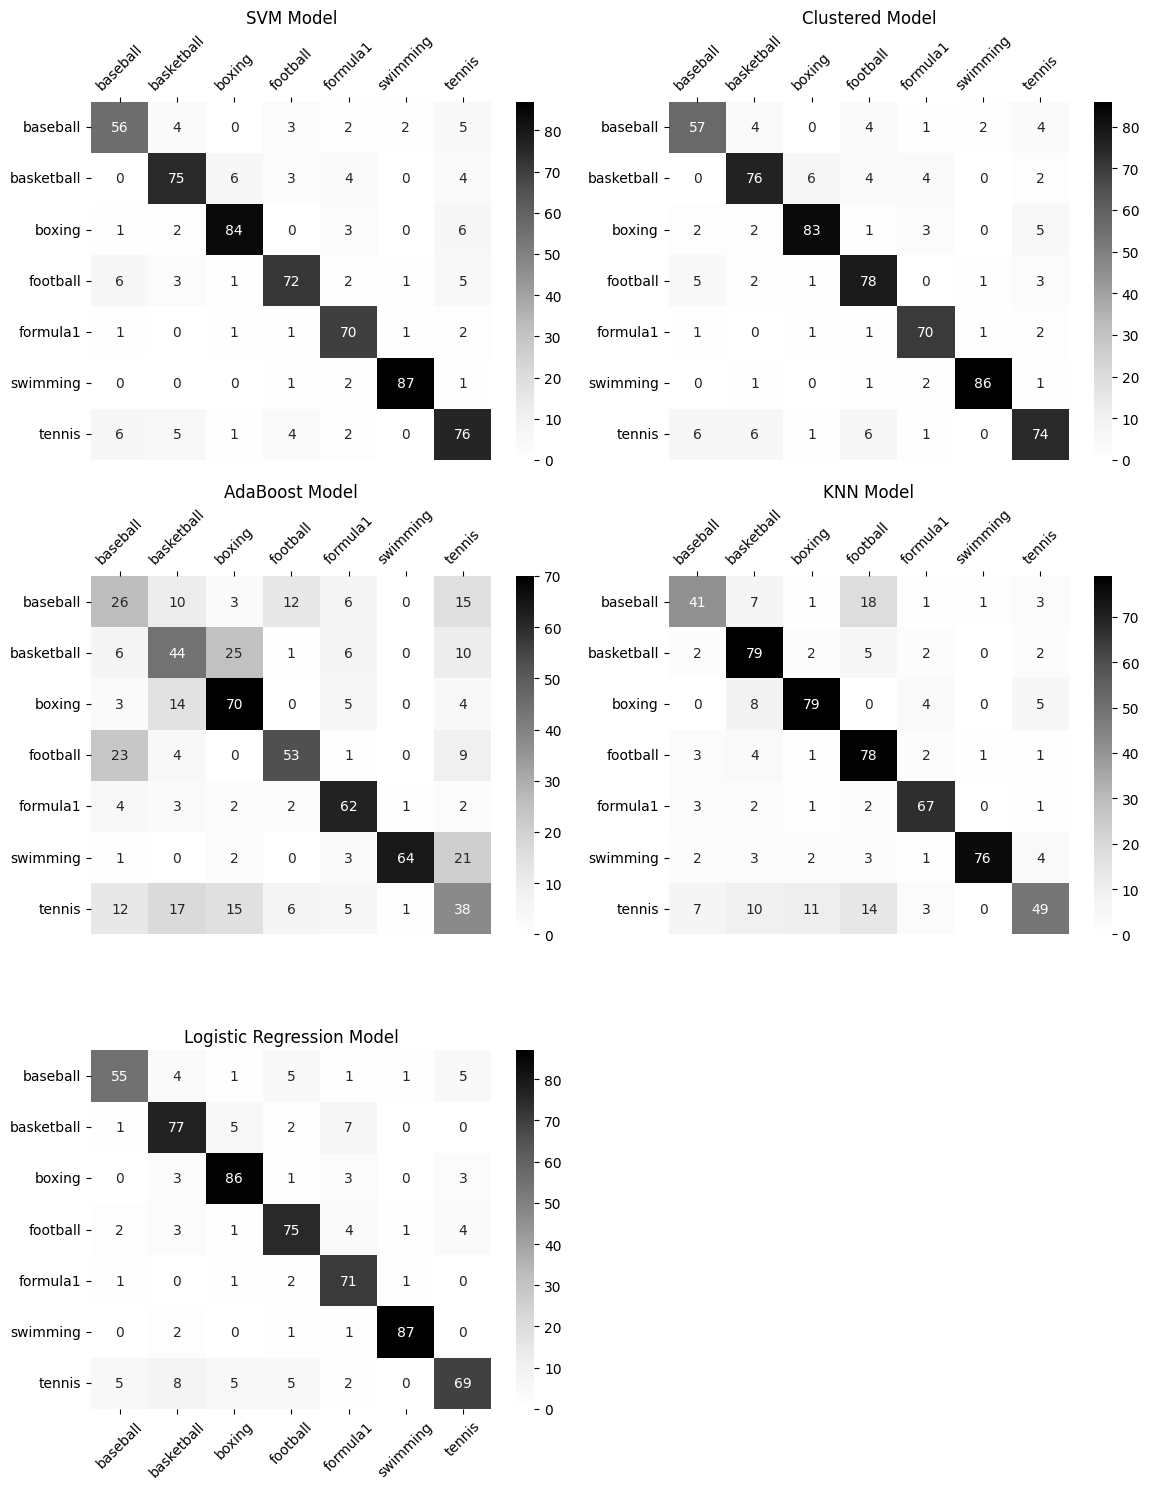

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and set of axes as a 3x2 grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# SVM Model
sns.heatmap(cm_linearSVM, annot=True, fmt='d', ax=axes[0, 0], cmap='Greys', xticklabels=categories, yticklabels=categories)
axes[0, 0].set_title('SVM Model')
axes[0, 0].xaxis.tick_top()  # Déplacer les ticks de l'axe des X en haut
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)  # Rotation des étiquettes pour une meilleure lisibilité

# Clustered Model
sns.heatmap(cm_clustered_model, annot=True, fmt='d', ax=axes[0, 1], cmap='Greys', xticklabels=categories, yticklabels=categories)
axes[0, 1].set_title('Clustered Model')
axes[0, 1].xaxis.tick_top()  # Même ajustement pour les étiquettes de l'axe des X
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# AdaBoost Model
sns.heatmap(cm_ada_model, annot=True, fmt='d', ax=axes[1, 0], cmap='Greys', xticklabels=categories, yticklabels=categories)
axes[1, 0].set_title('AdaBoost Model')
axes[1, 0].xaxis.tick_top()
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# KNN Model
sns.heatmap(cm_knn_model, annot=True, fmt='d', ax=axes[1, 1], cmap='Greys', xticklabels=categories, yticklabels=categories)
axes[1, 1].set_title('KNN Model')
axes[1, 1].xaxis.tick_top()
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

# Logistic Regression
sns.heatmap(cm_log_reg, annot=True, fmt='d', ax=axes[2, 0], cmap='Greys', xticklabels=categories, yticklabels=categories)
axes[2, 0].set_title('Logistic Regression Model')
axes[2, 0].xaxis.set_label_position('top')
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45)

# Adjust the display to avoid overlap and improve readability
plt.tight_layout()
fig.delaxes(axes[2][1])
plt.show()


The Y-axis (vertical) represents the true classes of the samples (the actual labels), while the X-axis (horizontal) shows the predictions made by the model. Each cell of the matrix shows the number of samples for a given combination of actual class and predicted class.<br>
The values ​​on the main diagonal (top left to bottom right) indicate the number of samples correctly classified for each class. Values ​​off the diagonal show classification errors.

###4.3.Which sports are easy or difficult to distinguish between ?

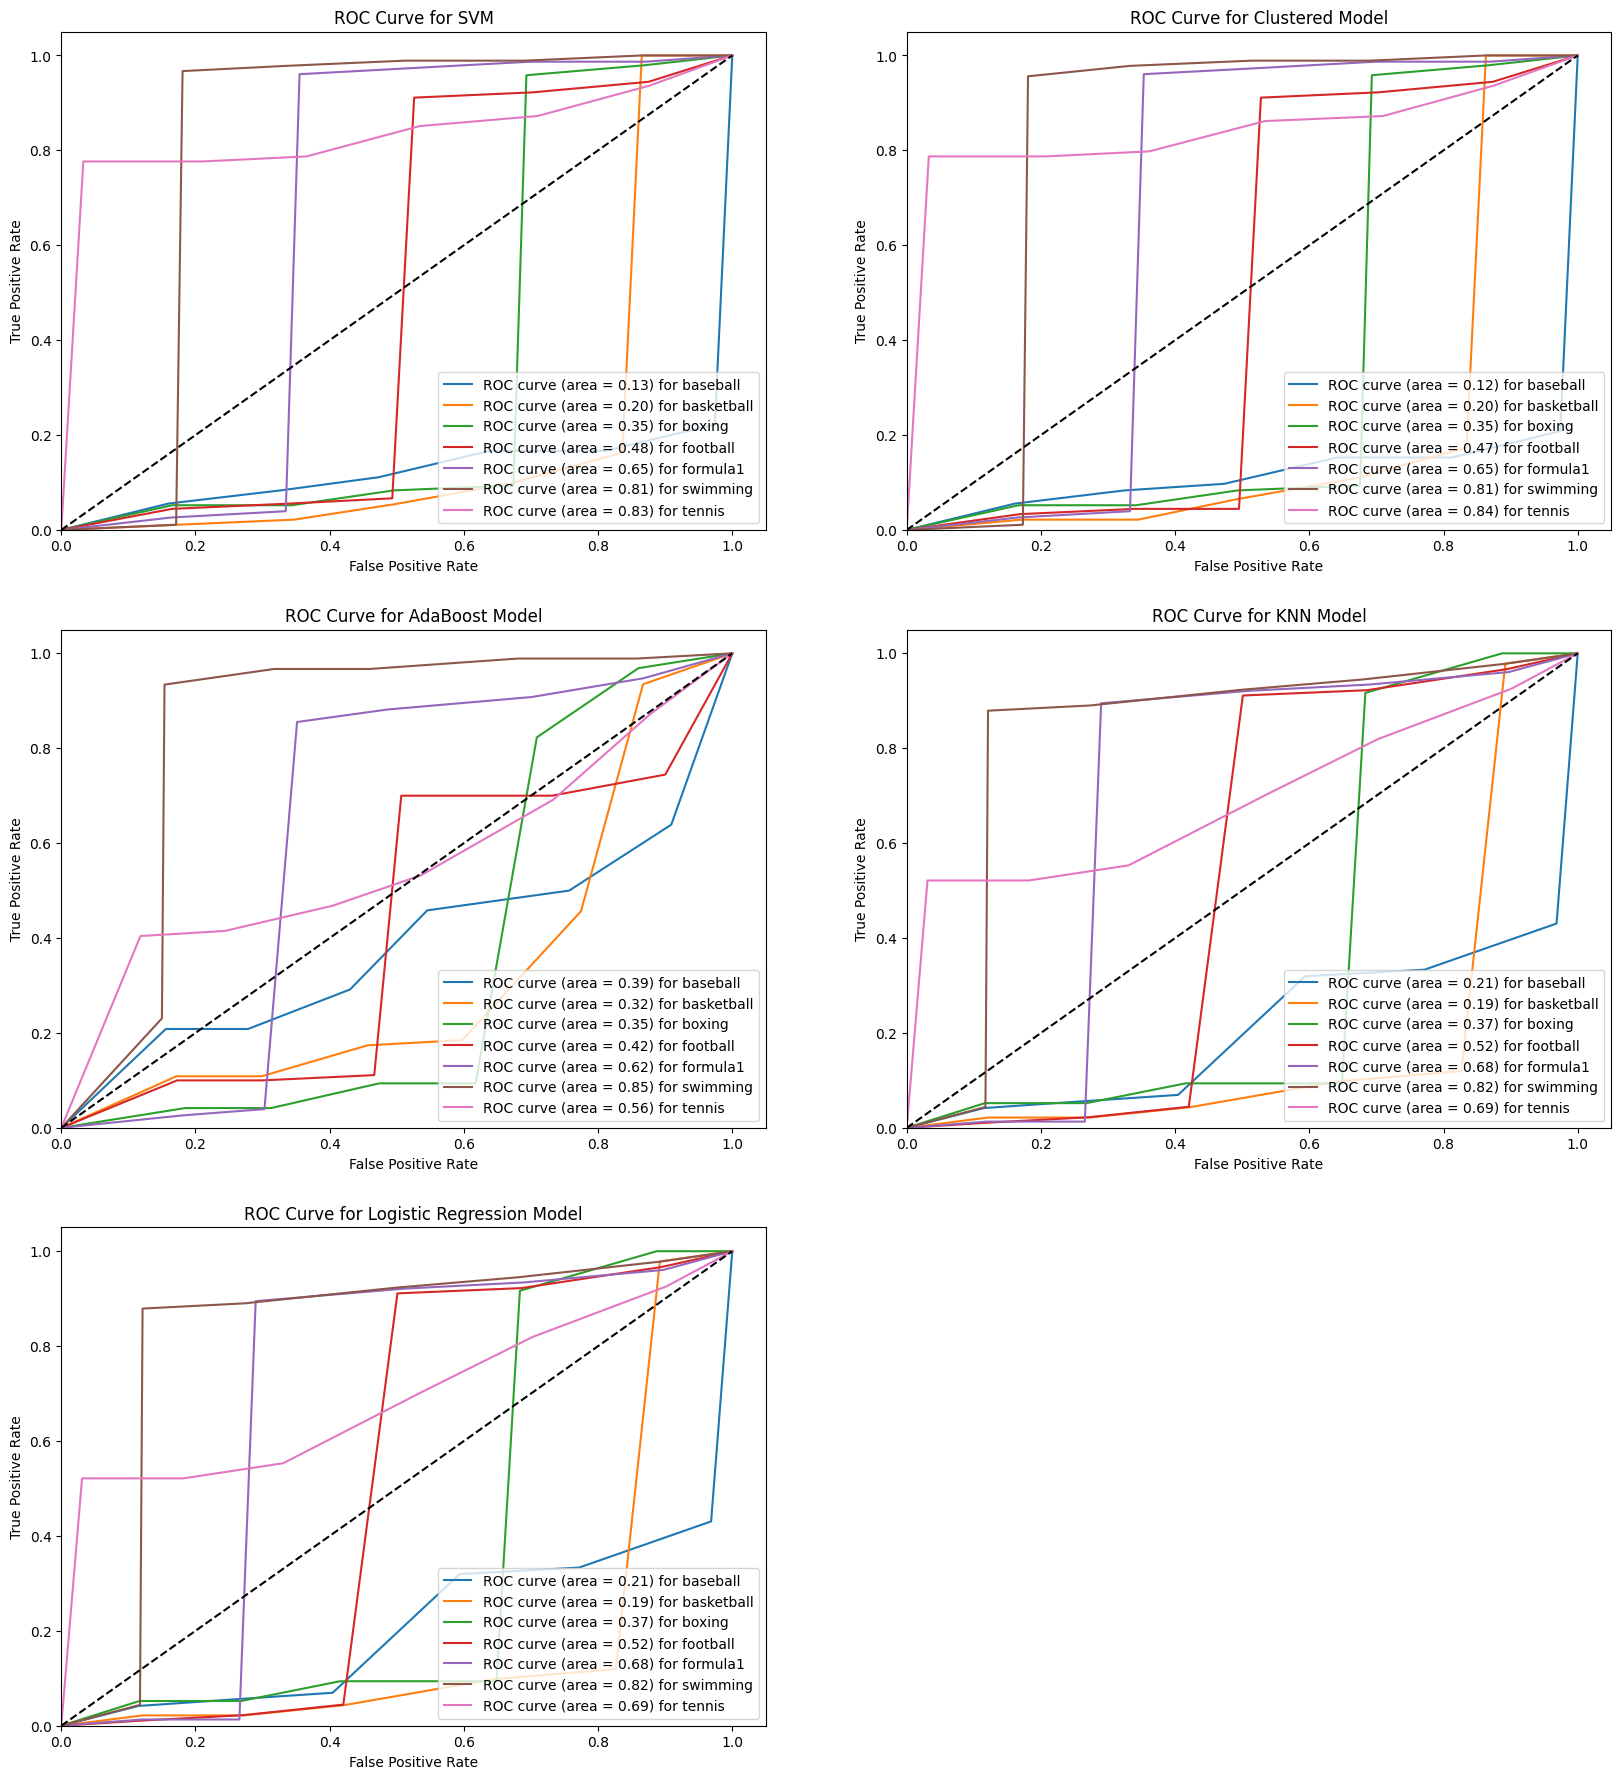

In [35]:
# plot Roc curve for the tensorflow model
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc

# calculate roc curve for multi-class classification
fpr_linearSVM = dict()
tpr_linearSVM = dict()
roc_auc_linearSVM = dict()
fpr_clustered_model = dict()
tpr_clustered_model = dict()
roc_auc_clustered_model = dict()
fpr_ada_model = dict()
tpr_ada_model = dict()
roc_auc_ada_model = dict()
fpr_knn_model = dict()
tpr_knn_model = dict()
roc_auc_knn_model = dict()
fpr_log_reg = dict()
tpr_log_reg = dict()
roc_auc_log_reg = dict()
for i in range(len(categories)):
    fpr_linearSVM[i], tpr_linearSVM[i], _ = roc_curve(test_labels, test_predictions, pos_label=i)
    roc_auc_linearSVM[i] = auc(fpr_linearSVM[i], tpr_linearSVM[i])
    fpr_clustered_model[i], tpr_clustered_model[i], _ = roc_curve(test_labels, test_predictions_clustered, pos_label=i)
    roc_auc_clustered_model[i] = auc(fpr_clustered_model[i], tpr_clustered_model[i])
    fpr_ada_model[i], tpr_ada_model[i], _ = roc_curve(test_labels, test_predictions_ada, pos_label=i)
    roc_auc_ada_model[i] = auc(fpr_ada_model[i], tpr_ada_model[i])
    fpr_knn_model[i], tpr_knn_model[i], _ = roc_curve(test_labels, test_predictions_knn, pos_label=i)
    roc_auc_knn_model[i] = auc(fpr_knn_model[i], tpr_knn_model[i])
    fpr_log_reg[i], tpr_log_reg[i], _ = roc_curve(test_labels, test_predictions_log_reg, pos_label=i)
    roc_auc_log_reg[i] = auc(fpr_log_reg[i], tpr_log_reg[i])

# plot roc curve
fig, axes = plt.subplots(3, 2, figsize=(20, 22))
for i in range(len(categories)):
    axes[0,0].plot(fpr_linearSVM[i], tpr_linearSVM[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc_linearSVM[i], categories[i]))
axes[0,0].plot([0, 1], [0, 1], 'k--')
axes[0,0].set_xlim([0.0, 1.05])
axes[0,0].set_ylim([0.0, 1.05])
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve for SVM')
axes[0,0].legend(loc='lower right')
for i in range(len(categories)):
    axes[0,1].plot(fpr_clustered_model[i], tpr_clustered_model[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc_clustered_model[i], categories[i]))
axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].set_xlim([0.0, 1.05])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve for Clustered Model')
axes[0,1].legend(loc='lower right')
for i in range(len(categories)):
    axes[1,0].plot(fpr_ada_model[i], tpr_ada_model[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc_ada_model[i], categories[i]))
axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_xlim([0.0, 1.05])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve for AdaBoost Model')
axes[1,0].legend(loc='lower right')
for i in range(len(categories)):
    axes[1,1].plot(fpr_knn_model[i], tpr_knn_model[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc_knn_model[i], categories[i]))
axes[1,1].plot([0, 1], [0, 1], 'k--')
axes[1,1].set_xlim([0.0, 1.05])
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve for KNN Model')
axes[1,1].legend(loc='lower right')
for i in range(len(categories)):
    axes[2,0].plot(fpr_knn_model[i], tpr_knn_model[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc_knn_model[i], categories[i]))
axes[2,0].plot([0, 1], [0, 1], 'k--')
axes[2,0].set_xlim([0.0, 1.05])
axes[2,0].set_ylim([0.0, 1.05])
axes[2,0].set_xlabel('False Positive Rate')
axes[2,0].set_ylabel('True Positive Rate')
axes[2,0].set_title('ROC Curve for Logistic Regression Model')
axes[2,0].legend(loc='lower right')
fig.delaxes(axes[2][1])
plt.show()

Used to evaluate the performance of a classification model.<br>
X-axis (X): False Positive Rate, shows the proportion of negative examples incorrectly classified as positive. The lower this rate, the better.<br>
Y axis (Y): Rate of True Positives, This axis shows the proportion of positive examples correctly identified. The higher this rate, the better.<br>
AUC is an overall indicator of model performance. In general, a higher AUC indicates a better model.<br>
We can see that the Clustered Linear SVM Model is the best one and tennis category demonstrates the highest level of prediction accuracy, whereas baseball category exhibits the lowest accuracy among the classes.

###4.4. Are there groups that are more similar to each other ?

Downloading...
From (original): https://drive.google.com/uc?id=1dmX5laQwy4JYHSPHO2H7MX6JYzKRH7iO
From (redirected): https://drive.google.com/uc?id=1dmX5laQwy4JYHSPHO2H7MX6JYzKRH7iO&confirm=t&uuid=17045140-d0e4-4a19-bc73-a31a443d9420
To: /content/data2.zip
100%|██████████| 84.7M/84.7M [00:00<00:00, 128MB/s]
Extracting : 100%|██████████| 3059/3059 [00:01<00:00, 1674.99it/s]


Importing dataset completed
The categories are:  ['baseball', 'basketball', 'boxing', 'football', 'formula1', 'swimming', 'tennis']
number of baseball images = 437
number of basketball images = 437
number of boxing images = 437
number of football images = 437
number of formula1 images = 437
number of swimming images = 437
number of tennis images = 437
102967424/102967424 [==============================] - 4s 0us/step
Extract features for the first 50 images of each category
Image processing of baseball...
1/1 [==============================] - 0s 196ms/step
Image processing of basketball...
1/1 [==============================] - 0s 207ms/step
Image processing of boxing...
1/1 [==============================] - 0s 191ms/step
Image processing of football...
1/1 [==============================] - 0s 190ms/step
Image processing of formula1...
1/1 [==============================] - 0s 328ms/step
Image processing of swimming...
1/1 [==============================] - 0s 203ms/step
Image proce

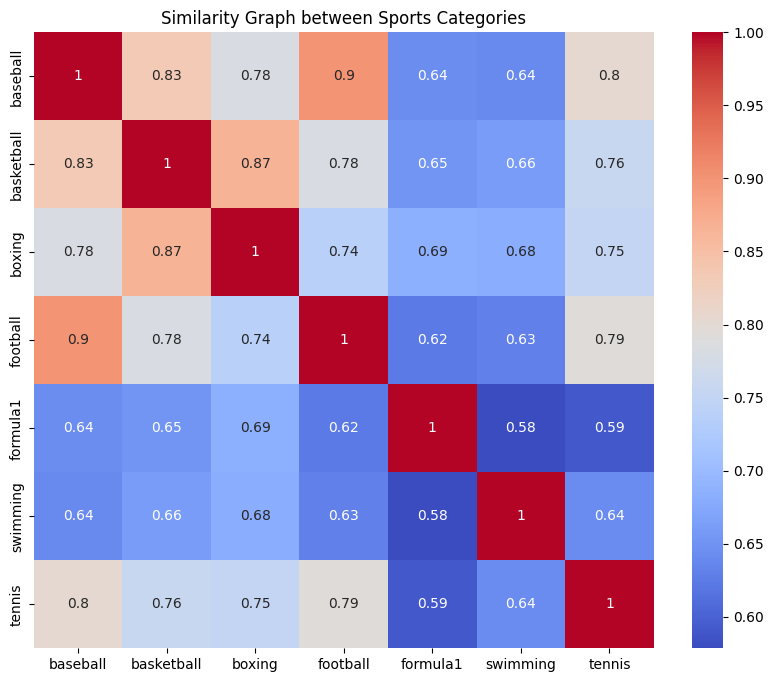

In [38]:
import seaborn as sns
import tqdm
import gdown
import zipfile
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load the dataset from the local folder
data_url = 'https://drive.google.com/file/d/1dmX5laQwy4JYHSPHO2H7MX6JYzKRH7iO/view?usp=sharing'
gdown.download(data_url, output='data2.zip', quiet=False, fuzzy=True)

# extract the dataset from the zip file
with zipfile.ZipFile("data2.zip","r") as zf:
    for member in tqdm.tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, 'data2')
        except zipfile.error as e:
            pass
print('Importing dataset completed')

data2_dir = pathlib.Path('./data')

# divide the dataset into 7 categories
categories2 = ['baseball', 'basketball', 'boxing', 'football', 'formula1', 'swimming', 'tennis']
label2id_dict2 = dict((name, index) for index, name in enumerate(categories2))
id2label_dict2 = dict((index, name) for index, name in enumerate(categories2))
print('The categories are: ', categories2)
dataset2 = []
for category in categories2:
    dataset2.append(list(data2_dir.glob(category+'/*.*')))
    print(f"number of {category} images = {len(list(data2_dir.glob(category+'/*.*')))}")

import matplotlib.pyplot as plt
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Function to extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    return features.flatten()

# Extract features for the first 50 images of each category
print('Extract features for the first 50 images of each category')
features_per_category = {}
for category in categories2:
    print(f"Image processing of {category}...")
    category_features = []
    for img_path in list(data2_dir.glob(f'{category}/*'))[:50]:
        features = extract_features(img_path, model)
        category_features.append(features)
    features_per_category[category] = np.mean(category_features, axis=0)

# Calculate similarity matrix
similarity_matrix = np.zeros((len(categories2), len(categories2)))
for i, category1 in enumerate(categories2):
    for j, category2 in enumerate(categories2):
        similarity = np.dot(features_per_category[category1], features_per_category[category2]) / (np.linalg.norm(features_per_category[category1]) * np.linalg.norm(features_per_category[category2]))
        similarity_matrix[i, j] = similarity

# Plot the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, xticklabels=categories2, yticklabels=categories2, cmap='coolwarm')
plt.title('Similarity Graph between Sports Categories')
plt.show()

In this graph, The more you get closer to 1, the more similarity there is between 2 sports. We can see that football and basball are the most similar with a coefficient of 0.9, swimming an formula1 the least with a coefficient of 0.58.

#5.Challenges
The challenges we faced in the project were with analyzing the images and their pixels. When the images had an average resolution of 476x322 pixels, it took a considerable amount of time to compute the results, and we did not receive any results at all. So we decided to reduce the resolution to 128x128 and we were able to obtain results, but they were so bad (like less than 50%),and in a second step we decided to reduce again to 64x64 and results were a little bit better (like 55%). After a long week of work, we concluded that we need to make progress on the resolution 128x128. So with the help of some adjustments (zoom,contrast on the images) and normalizatia, our program worked successfully and now have a success of 85-90%.

#6. Conclusion
Upon examining the graphical representations, it becomes clear that the SVM model (normal and Clustered Linear SVM) stands out for its exceptional performance in comparison to the alternative models presented. This observation leads to the inference that conventional machine learning techniques may find it challenging to fully grasp the complex nature of the dataset at hand, resulting in less than optimal performance. Given this context, it's prudent to suggest a pivot towards the utilization of more advanced deep learning methodologies, specifically the adoption of Neural Network models. Such a shift is anticipated to significantly boost the model's ability to accurately interpret and analyze the data, thereby markedly improving overall model performance.